In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
%matplotlib inline

import matplotlib.pyplot as plt
from matplotlib import gridspec
import numpy as np
import pandas as pd
import math

In [3]:
from src.utils import haversine, calc_xydist
from src.quadtree import Point, Rect, QuadTree

In [4]:
deg_offset = 0.05 # about 5 km

In [5]:
train_path = 'data/train.csv'

In [6]:
train = pd.read_csv(train_path)

In [7]:
train.shape

(431732, 17)

In [8]:
train.describe()

,floor_area_sqm,lease_commence_date,latitude,longitude,elevation,resale_price
count,431732.000000,431732.000000,431732.000000,431732.000000,431732.0,4.317320e+05
mean,96.970064,1989.421004,1.364939,103.836492,0.0,3.018196e+05
std,25.190664,10.254055,0.042829,0.073527,0.0,1.298623e+05
min,31.000000,1966.000000,1.270380,103.685228,0.0,2.970000e+04
25%,74.000000,1983.000000,1.336154,103.772439,0.0,2.052000e+05
50%,99.000000,1988.000000,1.358958,103.840160,0.0,2.839500e+05
75%,114.000000,1997.000000,1.389004,103.895779,0.0,3.735000e+05
max,280.000000,2019.000000,1.457071,103.987805,0.0,1.123200e+06


# Calculate SW and NE corner points to denote bounding area 

In [9]:
ref_min_lat = train['latitude'].min() - deg_offset
ref_min_long = train['longitude'].min() - deg_offset
ref_max_lat = train['latitude'].max() + deg_offset
ref_max_long = train['longitude'].max() + deg_offset

print(f"Reference Origin (lat, long): {ref_min_lat}, {ref_min_long}")
print(f"Maximum Coord (lat, long): {ref_max_lat}, {ref_max_long}")

Reference Origin (lat, long): 1.2203795117581597, 103.63522841782499
Maximum Coord (lat, long): 1.5070712161383, 104.037804503483


In [10]:
# 1st entry in data
train.iloc[0]
# manually validate coord in google maps

month                            2001-08
town                           pasir ris
flat_type                         4 room
block                                440
street_name            pasir ris drive 4
storey_range                    01 to 03
floor_area_sqm                       118
flat_model                       model a
eco_category               uncategorized
lease_commence_date                 1989
latitude                         1.36901
longitude                        103.959
elevation                              0
subzone                  pasir ris drive
planning_area                  pasir ris
region                       east region
resale_price                      209700
Name: 0, dtype: object

In [10]:
test_lat, test_long = train.iloc[0][['latitude','longitude']]

In [11]:
test_x, test_y = calc_xydist(test_long, test_lat, ref_min_long,ref_min_lat)
print(f"Distance to origin (x,y): {test_x},{test_y} km")

Distance to origin (x,y): 35.95775442315713,16.5267442089845 km


In [12]:
dist = haversine(test_long, test_lat, ref_min_long,ref_min_lat)
print(f"Euclid distance to origin: {dist} km")

Euclid distance to origin: 39.57487375074682 km


Above distance checked against visual inspection on Google Maps

# Quadtree data structure and radius search

In [13]:
width, height = calc_xydist(ref_max_long, ref_max_lat, ref_min_long,ref_min_lat)
width = math.ceil(width)
height = math.ceil(height)
print(width, height) # Bounding box size in km

45 32


In [14]:
mrt_data_path = 'data/auxiliary-data/sg-train-stations.csv'

In [15]:
mrt = pd.read_csv(mrt_data_path)

In [16]:
mrt.head()

,name,codes,lat,lng,opening_year,type
0,Eunos,EW7,1.319778,103.903252,1989.0,mrt
1,Chinese Garden,EW25,1.342352,103.732596,1988.0,mrt
2,Khatib,NS14,1.417383,103.832980,1988.0,mrt
3,Kranji,NS7,1.425177,103.762165,1996.0,mrt
4,Redhill,EW18,1.289562,103.816816,1988.0,mrt


In [17]:
mrt['x'] = np.nan
mrt['y'] = np.nan
mrt['long_name'] = mrt['name'] + '_' + mrt['type']

mrt.head()

,name,codes,lat,lng,opening_year,type,x,y,long_name
0,Eunos,EW7,1.319778,103.903252,1989.0,mrt,NaN,NaN,Eunos_mrt
1,Chinese Garden,EW25,1.342352,103.732596,1988.0,mrt,NaN,NaN,Chinese Garden_mrt
2,Khatib,NS14,1.417383,103.832980,1988.0,mrt,NaN,NaN,Khatib_mrt
3,Kranji,NS7,1.425177,103.762165,1996.0,mrt,NaN,NaN,Kranji_mrt
4,Redhill,EW18,1.289562,103.816816,1988.0,mrt,NaN,NaN,Redhill_mrt


In [18]:
def create_qtree(df, name_col = 'name'):
    qtree = QuadTree(domain, 3)
    points = []
    for index, row in df.iterrows():
        x, y = calc_xydist(row.lng, row.lat, ref_min_long,ref_min_lat)

        df['x'][index] = round(x, 2)
        df['y'][index] = round(y, 2)

        point = Point(x, y, name=row[name_col])

        points.append(point)
        qtree.insert(point)
        
    return qtree, points

In [19]:
# TODO: Better way?
domain = Rect(width/2, height/2, width, height)

mrt_qtree, mrt_points = create_qtree(mrt, name_col='long_name')
mrt.head()

C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


,name,codes,lat,lng,opening_year,type,x,y,long_name
0,Eunos,EW7,1.319778,103.903252,1989.0,mrt,29.79,11.05,Eunos_mrt
1,Chinese Garden,EW25,1.342352,103.732596,1988.0,mrt,10.82,13.56,Chinese Garden_mrt
2,Khatib,NS14,1.417383,103.832980,1988.0,mrt,21.98,21.91,Khatib_mrt
3,Kranji,NS7,1.425177,103.762165,1996.0,mrt,14.11,22.77,Kranji_mrt
4,Redhill,EW18,1.289562,103.816816,1988.0,mrt,20.19,7.69,Redhill_mrt


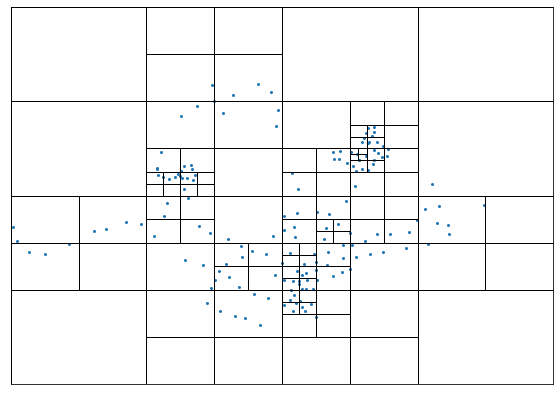

In [20]:
DPI = 72
fig = plt.figure(figsize=(700/DPI, 500/DPI), dpi=DPI)
ax = plt.subplot()
ax.set_xlim(0, width)
ax.set_ylim(0, height)
mrt_qtree.draw(ax)
ax.scatter([p.x for p in mrt_points], [p.y for p in mrt_points], s=4)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

Number of found points = 25
Oasis_other
Sam Kee_other
Farmway_other
Kadaloor_other
Coral Edge_other
Riviera_mrt
Cove_other
Kangkar_other
Meridian_other
Ranggung_other
Bakau_other
Rumbia_other
Cheng Lim_other
Compassvale_other
Sengkang_mrt
Sengkang_mrt
Punggol_mrt
Samudera_other
Nibong_other
Soo Teck_other
Damai_other
Punggol Point_other
Sumang_other
Punggol_mrt
Teck Lee_other


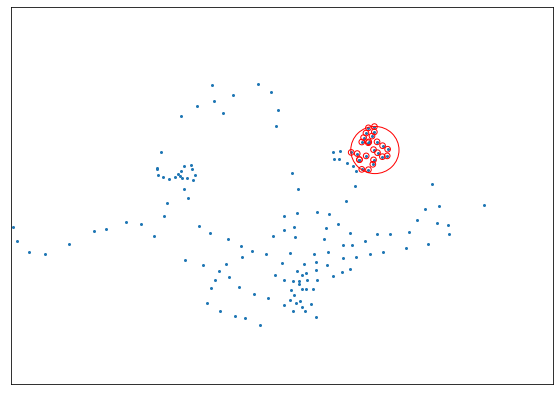

In [21]:
# Query point
(test_x,test_y) = (30.21,19.86)
centre = (test_x,test_y)
radius = 2 # in km 
found_points = []
mrt_qtree.query_radius((test_x,test_y), radius, found_points)


print('Number of found points =', len(found_points))
for p in found_points:
    print(p.name)

# Plot results
DPI = 72
fig = plt.figure(figsize=(700/DPI, 500/DPI), dpi=DPI)
ax = plt.subplot()

ax.set_xlim(0, width)
ax.set_ylim(0, height)

# Plot all points
ax.scatter([p.x for p in mrt_points], [p.y for p in mrt_points], s=4)
ax.set_xticks([])
ax.set_yticks([])

# Plot found points
ax.scatter([p.x for p in found_points], [p.y for p in found_points],
           facecolors='none', edgecolors='r', s=32)

# Draw search radius
circle = plt.Circle(centre, radius, ec='r', fill=False)
ax.add_patch(circle)
# Rect(*centre, 2*radius, 2*radius).draw(ax, c='r')

plt.show()

In [22]:
train.head()

,month,town,flat_type,block,street_name,storey_range,floor_area_sqm,flat_model,eco_category,lease_commence_date,latitude,longitude,elevation,subzone,planning_area,region,resale_price
0,2001-08,pasir ris,4 room,440,pasir ris drive 4,01 to 03,118.0,model a,uncategorized,1989,1.369008,103.958697,0.0,pasir ris drive,pasir ris,east region,209700.0
1,2014-10,punggol,5-room,196B,punggol field,10 to 12,110.0,improved,uncategorized,2003,1.399007,103.906991,0.0,punggol field,punggol,north-east region,402300.0
2,2020-09,sengkang,5 room,404A,fernvale lane,01 to 03,112.0,premium apartment,uncategorized,2004,1.388348,103.873815,0.0,fernvale,sengkang,north-east region,351000.0
3,2000-10,clementi,3 room,375,clementi avenue 4,07 to 09,67.0,new generation,uncategorized,1980,1.318493,103.766702,0.0,clementi north,clementi,west region,151200.0
4,2013-01,bukit batok,3-room,163,bukit batok street 11,07 to 09,73.0,model a,uncategorized,1985,1.348149,103.742658,0.0,bukit batok west,bukit batok,west region,318600.0


In [23]:
prisch_data_path = 'data/auxiliary-data/sg-primary-schools.csv'
prisch = pd.read_csv(prisch_data_path)

prisch['x'] = np.nan
prisch['y'] = np.nan

prisch_qtree, prisch_points = create_qtree(prisch)

prisch.head()
print(len(prisch_qtree))
print(len(prisch_points))

191
191


C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


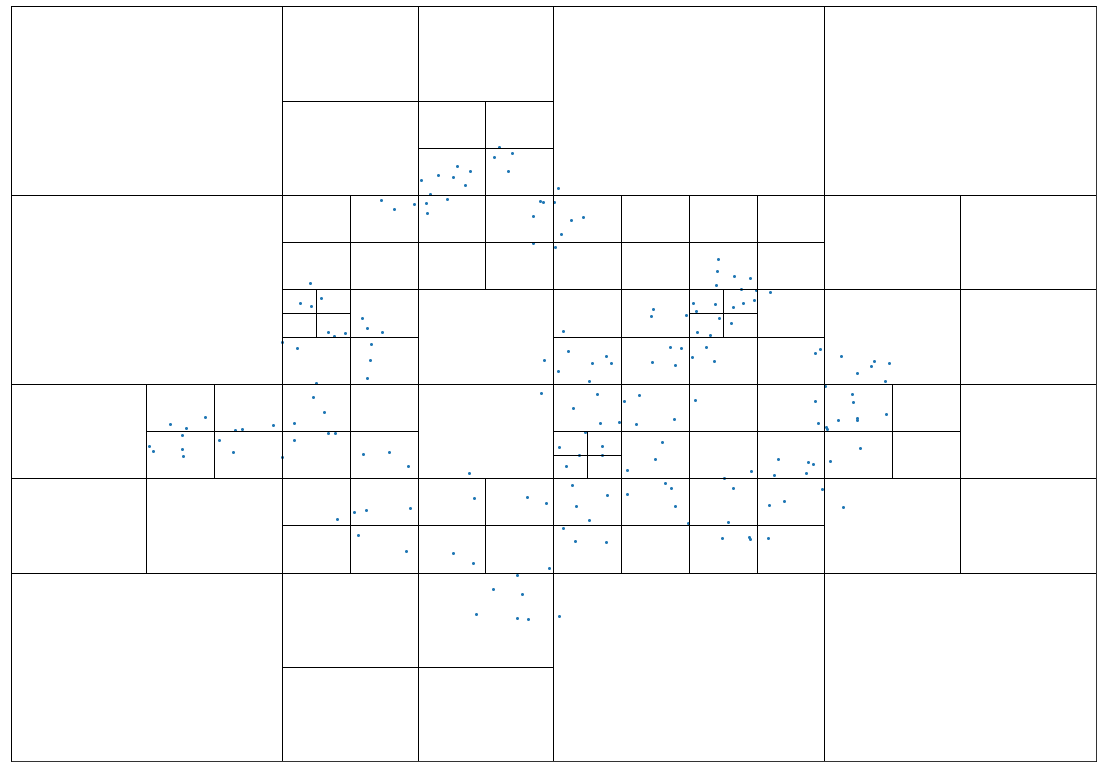

In [24]:
DPI = 72
fig = plt.figure(figsize=(1400/DPI, 1000/DPI), dpi=DPI)
ax = plt.subplot()
ax.set_xlim(0, width)
ax.set_ylim(0, height)
prisch_qtree.draw(ax)
ax.scatter([p.x for p in prisch_points], [p.y for p in prisch_points], s=4)
ax.set_xticks([])
ax.set_yticks([])
plt.show()

In [25]:
comm_data_path = 'data/auxiliary-data/sg-commerical-centres.csv'
comm = pd.read_csv(comm_data_path)

comm['x'] = np.nan
comm['y'] = np.nan
comm['long_name'] = comm['name'] + '_' + comm['type']
comm_qtree, comm_points = create_qtree(comm, name_col='long_name')

print(comm.head())
print(len(comm_qtree))
print(len(comm_points))

                        name type       lat         lng      x      y  \
0  Central Business District   CR  1.286768  103.854529  24.38   7.38   
1       Jurong Lake District   CR  1.334085  103.734513  11.04  12.64   
2    Seletar Regional Centre   CR  1.409435  103.866820  25.74  21.02   
3   Tampines Regional Centre   CR  1.353180  103.945188  34.46  14.77   
4  Woodlands Regional Centre   CR  1.436748  103.786485  16.81  24.06   

                      long_name  
0  Central Business District_CR  
1       Jurong Lake District_CR  
2    Seletar Regional Centre_CR  
3   Tampines Regional Centre_CR  
4  Woodlands Regional Centre_CR  
38
38


C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys
C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [26]:
# mrt_qtree
# prisch_qtree
# comm_qtree
train['x'] = np.nan
train['y'] = np.nan
train['prisch_1km'] = 0
train['comm_2km'] = 0
train['mrt_2km'] = 0

for index, row in train[:5].iterrows():
    x, y = calc_xydist(row.longitude, row.latitude, ref_min_long,ref_min_lat)
    x = round(x, 2)
    y = round(y, 2)
    
    train['x'][index] = x
    train['y'][index] = y

    # MRT Search
    mrt_radius = 2
    found_points = []
    mrt_qtree.query_radius((x, y), mrt_radius, found_points)
    train['mrt_2km'][index] = len(found_points)
    
    # Commercial centres
    comm_radius = 2
    found_points = []
    comm_qtree.query_radius((x, y), comm_radius, found_points)
    train['comm_2km'][index] = len(found_points)
    
    # Primary Schools
    prisch_radius = 1
    found_points = []
    prisch_qtree.query_radius((x, y), prisch_radius, found_points)
    train['prisch_1km'][index] = len(found_points)
    
print(train.head(7))

     month         town flat_type block                street_name  \
0  2001-08    pasir ris    4 room   440          pasir ris drive 4   
1  2014-10      punggol    5-room  196B              punggol field   
2  2020-09     sengkang    5 room  404A              fernvale lane   
3  2000-10     clementi    3 room   375          clementi avenue 4   
4  2013-01  bukit batok    3-room   163      bukit batok street 11   
5  2001-01  bukit batok    3 room   240  Bukit Batok East Avenue 5   
6  2007-09  jurong west    4 room   647      jurong west street 61   

  storey_range  floor_area_sqm         flat_model   eco_category  \
0     01 to 03           118.0            model a  uncategorized   
1     10 to 12           110.0           improved  uncategorized   
2     01 to 03           112.0  premium apartment  uncategorized   
3     07 to 09            67.0     new generation  uncategorized   
4     07 to 09            73.0            model a  uncategorized   
5     10 to 12            67.0 

C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  from ipykernel import kernelapp as app
C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  app.launch_new_instance()
C:\Users\dpramr\AppData\Roaming\Python\Python37\site-packages\ipykernel_launcher.py:22: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#retur